- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [10]:
import time

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset
from src.plot_utils import show_image_pairs, plot_training_metrics, show_test_results

cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using device: cuda


In [11]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = PairedImageDataset("generator_bot/screenshots", transforms=transform)

dataset_size = len(full_dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

print(f"Total dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

print(f"Train batches: {len(train_dl)}")
print(f"Test batches: {len(test_dl)}")

Total dataset size: 3600
Train size: 2880
Test size: 720
Train batches: 720
Test batches: 180


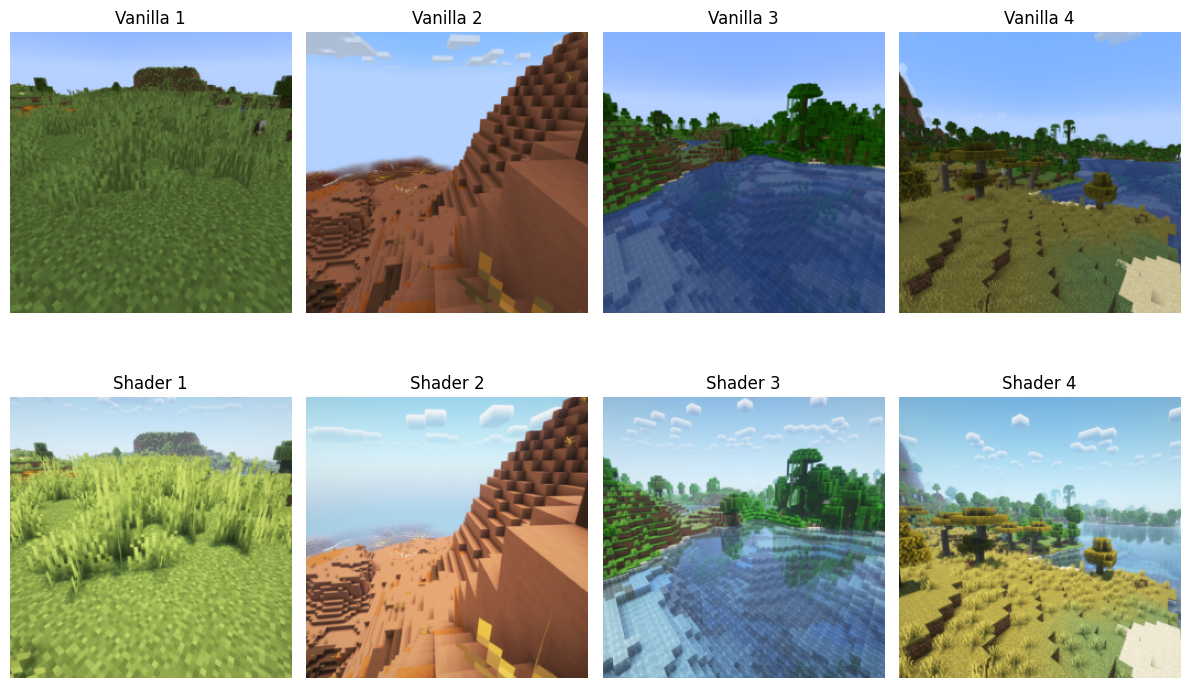

In [12]:
show_image_pairs(train_dl, num_pairs=4)

In [13]:
from src.models import GeneratorUNet, PatchDiscriminator, weights_init_normal

G = GeneratorUNet().to(device)
D = PatchDiscriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [14]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, l1_crit, lambda_l1=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    total_real_loss = 0
    total_fake_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for idx, batch in enumerate(loop):
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_l1 = l1_crit(y_fake, y) * lambda_l1
        g_loss = g_gan + g_l1
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        total_gan_loss += g_gan.item()
        total_l1_loss += g_l1.item()
        total_real_loss += d_real_loss.item()
        total_fake_loss += d_fake_loss.item()
        num_batches += 1

        loop.set_postfix(
            d_loss=total_discriminator_loss / (idx + 1),
            d_real_loss=total_real_loss / (idx + 1),
            d_fake_loss=total_fake_loss / (idx + 1),
            g_loss=total_generator_loss / (idx + 1),
            g_gan=total_gan_loss / (idx + 1),
            g_l1=total_l1_loss / (idx + 1),
        )

    return {
        "discriminator_loss": total_discriminator_loss / num_batches,
        "generator_loss": total_generator_loss / num_batches,
        "gan_loss": total_gan_loss / num_batches,
        "l1_loss": total_l1_loss / num_batches,
        "real_loss": total_real_loss / num_batches,
        "fake_loss": total_fake_loss / num_batches,
    }

In [15]:
def evaluate_model(dataloader, G, D, gan_crit, l1_crit, lambda_l1=100):
    """Evaluate the model on test data"""
    G.eval()
    D.eval()
    
    total_generator_loss = 0
    total_discriminator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            x = batch["vanilla"].to(device, non_blocking=True)
            y = batch["shader"].to(device, non_blocking=True)
            
            valid = torch.ones((x.size(0), 1, 16, 16), device=device)
            fake = torch.zeros_like(valid)
            
            # Generate fake images
            y_fake = G(x)
            
            # Discriminator loss
            real_pred = D(x, y)
            fake_pred = D(x, y_fake)
            d_real_loss = gan_crit(real_pred, valid)
            d_fake_loss = gan_crit(fake_pred, fake)
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            
            # Generator loss
            fake_pred = D(x, y_fake)
            g_gan = gan_crit(fake_pred, valid)
            g_l1 = l1_crit(y_fake, y) * lambda_l1
            g_loss = g_gan + g_l1
            
            total_generator_loss += g_loss.item()
            total_discriminator_loss += d_loss.item()
            total_gan_loss += g_gan.item()
            total_l1_loss += g_l1.item()
            num_batches += 1
    
    return {
        "test_generator_loss": total_generator_loss / num_batches,
        "test_discriminator_loss": total_discriminator_loss / num_batches,
        "test_gan_loss": total_gan_loss / num_batches,
        "test_l1_loss": total_l1_loss / num_batches,
    }


In [16]:
from src.checkpoint_utils import save_checkpoint, load_checkpoint

prev_time = time.time()

EPOCHS = 100
CHECKPOINT_FREQUENCY = 10  # Save checkpoint every 10 epochs
LOAD_CHECKPOINT = None  # Set to epoch number to load specific checkpoint, or None to start fresh

# Load checkpoint or start fresh
checkpoint_dir = "checkpoints"
if LOAD_CHECKPOINT is not None:
    start_epoch, train_metrics, test_metrics = load_checkpoint(LOAD_CHECKPOINT, G, D, g_opt, d_opt, device)
else:
    print("Starting training from scratch.")
    start_epoch, train_metrics, test_metrics = 0, [], []

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Train
    train_results = train_epoch(train_dl, G, D, g_opt, d_opt, gan_criterion, l1_criterion)
    train_metrics.append(train_results)

    # Evaluate on test set
    test_results = evaluate_model(test_dl, G, D, gan_criterion, l1_criterion)
    test_metrics.append(test_results)

    # Print results
    print(f"Train - G Loss: {train_results['generator_loss']:.4f}, D Loss: {train_results['discriminator_loss']:.4f}")
    print(f"Test  - G Loss: {test_results['test_generator_loss']:.4f}, D Loss: {test_results['test_discriminator_loss']:.4f}")

    current_time = time.time()
    elapsed = current_time - prev_time
    print(f"Time elapsed: {elapsed:.2f}s")
    prev_time = current_time

    if (epoch + 1) % CHECKPOINT_FREQUENCY == 0:
        save_checkpoint(epoch, G, D, g_opt, d_opt, train_metrics, test_metrics)
    elif epoch == EPOCHS - 1:
        save_checkpoint(epoch, G, D, g_opt, d_opt, train_metrics, test_metrics)

Starting training from scratch.

Epoch 1/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.67pairs/s, d_fake_loss=0.509, d_loss=0.517, d_real_loss=0.525, g_gan=1.41, g_l1=14.6, g_loss=16]  


Train - G Loss: 16.0461, D Loss: 0.5171
Test  - G Loss: 13.9421, D Loss: 0.5714
Time elapsed: 97.28s

Epoch 2/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.35pairs/s, d_fake_loss=0.465, d_loss=0.479, d_real_loss=0.493, g_gan=1.53, g_l1=11.9, g_loss=13.4]


Train - G Loss: 13.4002, D Loss: 0.4790
Test  - G Loss: 12.1843, D Loss: 0.4448
Time elapsed: 95.73s

Epoch 3/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.48pairs/s, d_fake_loss=0.454, d_loss=0.469, d_real_loss=0.484, g_gan=1.6, g_l1=11.2, g_loss=12.8] 


Train - G Loss: 12.7783, D Loss: 0.4691
Test  - G Loss: 12.7701, D Loss: 0.4226
Time elapsed: 95.52s

Epoch 4/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.42pairs/s, d_fake_loss=0.417, d_loss=0.428, d_real_loss=0.438, g_gan=1.93, g_l1=10.9, g_loss=12.8]


Train - G Loss: 12.8215, D Loss: 0.4279
Test  - G Loss: 11.7814, D Loss: 0.3576
Time elapsed: 99.10s

Epoch 5/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.27pairs/s, d_fake_loss=0.425, d_loss=0.434, d_real_loss=0.444, g_gan=2.05, g_l1=10.5, g_loss=12.5]


Train - G Loss: 12.5437, D Loss: 0.4345
Test  - G Loss: 12.8568, D Loss: 0.5215
Time elapsed: 98.39s

Epoch 6/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.39pairs/s, d_fake_loss=0.359, d_loss=0.367, d_real_loss=0.376, g_gan=2.49, g_l1=10.4, g_loss=12.8]


Train - G Loss: 12.8472, D Loss: 0.3675
Test  - G Loss: 12.4641, D Loss: 0.2618
Time elapsed: 101.71s

Epoch 7/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:29<00:00, 32.27pairs/s, d_fake_loss=0.328, d_loss=0.331, d_real_loss=0.334, g_gan=2.69, g_l1=10.1, g_loss=12.8]


Train - G Loss: 12.8019, D Loss: 0.3310
Test  - G Loss: 13.1923, D Loss: 0.1352
Time elapsed: 101.72s

Epoch 8/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.33pairs/s, d_fake_loss=0.299, d_loss=0.305, d_real_loss=0.312, g_gan=3.05, g_l1=10.1, g_loss=13.1]


Train - G Loss: 13.1095, D Loss: 0.3052
Test  - G Loss: 13.7635, D Loss: 0.2101
Time elapsed: 95.16s

Epoch 9/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 34.80pairs/s, d_fake_loss=0.287, d_loss=0.296, d_real_loss=0.306, g_gan=3, g_l1=9.86, g_loss=12.9]   


Train - G Loss: 12.8596, D Loss: 0.2964
Test  - G Loss: 12.7709, D Loss: 0.1348
Time elapsed: 93.96s

Epoch 10/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.62pairs/s, d_fake_loss=0.322, d_loss=0.319, d_real_loss=0.316, g_gan=2.96, g_l1=9.66, g_loss=12.6] 


Train - G Loss: 12.6232, D Loss: 0.3190
Test  - G Loss: 13.6823, D Loss: 0.2279
Time elapsed: 94.54s
Checkpoint saved: checkpoints\checkpoint_epoch_10.pth

Epoch 11/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 35.11pairs/s, d_fake_loss=0.297, d_loss=0.305, d_real_loss=0.312, g_gan=3.11, g_l1=9.61, g_loss=12.7]


Train - G Loss: 12.7219, D Loss: 0.3049
Test  - G Loss: 11.7012, D Loss: 0.2965
Time elapsed: 94.29s

Epoch 12/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.49pairs/s, d_fake_loss=0.26, d_loss=0.265, d_real_loss=0.271, g_gan=2.98, g_l1=9.48, g_loss=12.5] 


Train - G Loss: 12.4534, D Loss: 0.2651
Test  - G Loss: 12.7706, D Loss: 0.2539
Time elapsed: 95.96s

Epoch 13/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.53pairs/s, d_fake_loss=0.288, d_loss=0.298, d_real_loss=0.307, g_gan=3.08, g_l1=9.42, g_loss=12.5]


Train - G Loss: 12.5013, D Loss: 0.2976
Test  - G Loss: 11.2207, D Loss: 0.2972
Time elapsed: 95.75s

Epoch 14/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.15pairs/s, d_fake_loss=0.269, d_loss=0.272, d_real_loss=0.275, g_gan=2.87, g_l1=9.26, g_loss=12.1]


Train - G Loss: 12.1309, D Loss: 0.2722
Test  - G Loss: 11.4667, D Loss: 0.2339
Time elapsed: 94.42s

Epoch 15/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.21pairs/s, d_fake_loss=0.275, d_loss=0.28, d_real_loss=0.286, g_gan=3.01, g_l1=9.25, g_loss=12.3] 


Train - G Loss: 12.2573, D Loss: 0.2804
Test  - G Loss: 12.9783, D Loss: 0.2037
Time elapsed: 95.67s

Epoch 16/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.31pairs/s, d_fake_loss=0.255, d_loss=0.262, d_real_loss=0.268, g_gan=3.12, g_l1=9.2, g_loss=12.3] 


Train - G Loss: 12.3111, D Loss: 0.2615
Test  - G Loss: 12.1786, D Loss: 0.1651
Time elapsed: 99.08s

Epoch 17/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:29<00:00, 32.34pairs/s, d_fake_loss=0.258, d_loss=0.261, d_real_loss=0.265, g_gan=3.29, g_l1=9.18, g_loss=12.5]


Train - G Loss: 12.4656, D Loss: 0.2613
Test  - G Loss: 11.4263, D Loss: 0.2901
Time elapsed: 101.32s

Epoch 18/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.18pairs/s, d_fake_loss=0.236, d_loss=0.24, d_real_loss=0.244, g_gan=3.08, g_l1=9.03, g_loss=12.1] 


Train - G Loss: 12.1092, D Loss: 0.2401
Test  - G Loss: 11.6612, D Loss: 0.2229
Time elapsed: 99.17s

Epoch 19/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.55pairs/s, d_fake_loss=0.233, d_loss=0.24, d_real_loss=0.246, g_gan=3.28, g_l1=9.02, g_loss=12.3] 


Train - G Loss: 12.2944, D Loss: 0.2397
Test  - G Loss: 11.8968, D Loss: 0.1975
Time elapsed: 100.96s

Epoch 20/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.58pairs/s, d_fake_loss=0.301, d_loss=0.295, d_real_loss=0.289, g_gan=3.13, g_l1=8.9, g_loss=12]    


Train - G Loss: 12.0269, D Loss: 0.2947
Test  - G Loss: 13.4489, D Loss: 0.3796
Time elapsed: 100.93s
Checkpoint saved: checkpoints\checkpoint_epoch_20.pth

Epoch 21/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 32.94pairs/s, d_fake_loss=0.271, d_loss=0.275, d_real_loss=0.279, g_gan=3.17, g_l1=8.88, g_loss=12.1]


Train - G Loss: 12.0574, D Loss: 0.2753
Test  - G Loss: 11.7753, D Loss: 0.1702
Time elapsed: 101.63s

Epoch 22/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.61pairs/s, d_fake_loss=0.197, d_loss=0.201, d_real_loss=0.205, g_gan=3.34, g_l1=8.89, g_loss=12.2]


Train - G Loss: 12.2297, D Loss: 0.2011
Test  - G Loss: 11.6560, D Loss: 0.1781
Time elapsed: 95.81s

Epoch 23/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.56pairs/s, d_fake_loss=0.312, d_loss=0.309, d_real_loss=0.307, g_gan=3.06, g_l1=8.75, g_loss=11.8]


Train - G Loss: 11.8141, D Loss: 0.3094
Test  - G Loss: 11.5927, D Loss: 0.2238
Time elapsed: 101.28s

Epoch 24/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.14pairs/s, d_fake_loss=0.217, d_loss=0.226, d_real_loss=0.234, g_gan=3.32, g_l1=8.81, g_loss=12.1]


Train - G Loss: 12.1224, D Loss: 0.2255
Test  - G Loss: 11.7889, D Loss: 0.2286
Time elapsed: 94.36s

Epoch 25/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.29pairs/s, d_fake_loss=0.2, d_loss=0.205, d_real_loss=0.209, g_gan=3.49, g_l1=8.78, g_loss=12.3]  


Train - G Loss: 12.2642, D Loss: 0.2046
Test  - G Loss: 11.7096, D Loss: 0.2258
Time elapsed: 96.61s

Epoch 26/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 32.73pairs/s, d_fake_loss=0.238, d_loss=0.245, d_real_loss=0.251, g_gan=3.49, g_l1=8.75, g_loss=12.2]


Train - G Loss: 12.2400, D Loss: 0.2447
Test  - G Loss: 10.7708, D Loss: 0.2954
Time elapsed: 100.18s

Epoch 27/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.44pairs/s, d_fake_loss=0.207, d_loss=0.208, d_real_loss=0.21, g_gan=3.43, g_l1=8.72, g_loss=12.1] 


Train - G Loss: 12.1458, D Loss: 0.2084
Test  - G Loss: 11.7703, D Loss: 0.1914
Time elapsed: 95.69s

Epoch 28/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.24pairs/s, d_fake_loss=0.222, d_loss=0.226, d_real_loss=0.23, g_gan=3.48, g_l1=8.7, g_loss=12.2]  


Train - G Loss: 12.1746, D Loss: 0.2257
Test  - G Loss: 12.8015, D Loss: 0.2257
Time elapsed: 99.13s

Epoch 29/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.38pairs/s, d_fake_loss=0.203, d_loss=0.206, d_real_loss=0.21, g_gan=3.49, g_l1=8.63, g_loss=12.1] 


Train - G Loss: 12.1271, D Loss: 0.2064
Test  - G Loss: 14.4287, D Loss: 0.7414
Time elapsed: 98.72s

Epoch 30/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.73pairs/s, d_fake_loss=0.238, d_loss=0.241, d_real_loss=0.245, g_gan=3.52, g_l1=8.61, g_loss=12.1]


Train - G Loss: 12.1247, D Loss: 0.2413
Test  - G Loss: 13.3407, D Loss: 0.1101
Time elapsed: 98.08s
Checkpoint saved: checkpoints\checkpoint_epoch_30.pth

Epoch 31/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.08pairs/s, d_fake_loss=0.213, d_loss=0.215, d_real_loss=0.218, g_gan=3.59, g_l1=8.58, g_loss=12.2]  


Train - G Loss: 12.1733, D Loss: 0.2154
Test  - G Loss: 12.2117, D Loss: 0.1861
Time elapsed: 97.60s

Epoch 32/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.24pairs/s, d_fake_loss=0.248, d_loss=0.247, d_real_loss=0.247, g_gan=3.45, g_l1=8.55, g_loss=12]   


Train - G Loss: 12.0011, D Loss: 0.2472
Test  - G Loss: 11.9178, D Loss: 0.1810
Time elapsed: 96.45s

Epoch 33/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.22pairs/s, d_fake_loss=0.176, d_loss=0.179, d_real_loss=0.181, g_gan=3.6, g_l1=8.6, g_loss=12.2]  


Train - G Loss: 12.2032, D Loss: 0.1785
Test  - G Loss: 12.5596, D Loss: 0.1478
Time elapsed: 96.71s

Epoch 34/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.67pairs/s, d_fake_loss=0.186, d_loss=0.192, d_real_loss=0.197, g_gan=3.73, g_l1=8.53, g_loss=12.3]  


Train - G Loss: 12.2634, D Loss: 0.1915
Test  - G Loss: 12.6220, D Loss: 0.1372
Time elapsed: 97.76s

Epoch 35/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.31pairs/s, d_fake_loss=0.3, d_loss=0.285, d_real_loss=0.27, g_gan=3.41, g_l1=8.48, g_loss=11.9]    


Train - G Loss: 11.8855, D Loss: 0.2853
Test  - G Loss: 12.0389, D Loss: 0.1397
Time elapsed: 95.92s

Epoch 36/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.87pairs/s, d_fake_loss=0.189, d_loss=0.191, d_real_loss=0.192, g_gan=3.68, g_l1=8.45, g_loss=12.1] 


Train - G Loss: 12.1268, D Loss: 0.1907
Test  - G Loss: 13.2803, D Loss: 0.2005
Time elapsed: 97.10s

Epoch 37/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.81pairs/s, d_fake_loss=0.249, d_loss=0.264, d_real_loss=0.279, g_gan=3.67, g_l1=8.44, g_loss=12.1]


Train - G Loss: 12.1142, D Loss: 0.2641
Test  - G Loss: 12.6285, D Loss: 0.2233
Time elapsed: 97.61s

Epoch 38/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 32.95pairs/s, d_fake_loss=0.192, d_loss=0.197, d_real_loss=0.202, g_gan=3.6, g_l1=8.41, g_loss=12]   


Train - G Loss: 12.0098, D Loss: 0.1970
Test  - G Loss: 9.9757, D Loss: 0.4440
Time elapsed: 99.86s

Epoch 39/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 33.00pairs/s, d_fake_loss=0.19, d_loss=0.199, d_real_loss=0.208, g_gan=3.64, g_l1=8.37, g_loss=12]   


Train - G Loss: 12.0112, D Loss: 0.1991
Test  - G Loss: 12.6915, D Loss: 0.1947
Time elapsed: 99.62s

Epoch 40/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.29pairs/s, d_fake_loss=0.187, d_loss=0.192, d_real_loss=0.196, g_gan=3.66, g_l1=8.4, g_loss=12.1] 


Train - G Loss: 12.0606, D Loss: 0.1917
Test  - G Loss: 13.3824, D Loss: 0.1836
Time elapsed: 99.24s
Checkpoint saved: checkpoints\checkpoint_epoch_40.pth

Epoch 41/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.69pairs/s, d_fake_loss=0.199, d_loss=0.205, d_real_loss=0.212, g_gan=3.88, g_l1=8.36, g_loss=12.2]


Train - G Loss: 12.2423, D Loss: 0.2051
Test  - G Loss: 11.7706, D Loss: 0.1945
Time elapsed: 101.37s

Epoch 42/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 32.85pairs/s, d_fake_loss=0.195, d_loss=0.201, d_real_loss=0.208, g_gan=3.78, g_l1=8.37, g_loss=12.2]  


Train - G Loss: 12.1533, D Loss: 0.2012
Test  - G Loss: 12.6485, D Loss: 0.1437
Time elapsed: 99.45s

Epoch 43/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.63pairs/s, d_fake_loss=0.164, d_loss=0.17, d_real_loss=0.176, g_gan=3.84, g_l1=8.36, g_loss=12.2]   


Train - G Loss: 12.1918, D Loss: 0.1700
Test  - G Loss: 13.0147, D Loss: 0.1606
Time elapsed: 100.06s

Epoch 44/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.87pairs/s, d_fake_loss=0.243, d_loss=0.25, d_real_loss=0.256, g_gan=3.88, g_l1=8.3, g_loss=12.2]   


Train - G Loss: 12.1827, D Loss: 0.2496
Test  - G Loss: 12.2548, D Loss: 0.1569
Time elapsed: 96.55s

Epoch 45/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.50pairs/s, d_fake_loss=0.155, d_loss=0.159, d_real_loss=0.163, g_gan=3.76, g_l1=8.3, g_loss=12.1] 


Train - G Loss: 12.0620, D Loss: 0.1589
Test  - G Loss: 13.4292, D Loss: 0.2057
Time elapsed: 97.38s

Epoch 46/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.78pairs/s, d_fake_loss=0.166, d_loss=0.172, d_real_loss=0.177, g_gan=3.99, g_l1=8.39, g_loss=12.4]  


Train - G Loss: 12.3802, D Loss: 0.1716
Test  - G Loss: 13.8578, D Loss: 0.1037
Time elapsed: 96.81s

Epoch 47/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.73pairs/s, d_fake_loss=0.203, d_loss=0.213, d_real_loss=0.223, g_gan=4.2, g_l1=8.39, g_loss=12.6]   


Train - G Loss: 12.5930, D Loss: 0.2128
Test  - G Loss: 11.1477, D Loss: 0.3101
Time elapsed: 96.72s

Epoch 48/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.23pairs/s, d_fake_loss=0.163, d_loss=0.167, d_real_loss=0.171, g_gan=3.8, g_l1=8.25, g_loss=12]   


Train - G Loss: 12.0423, D Loss: 0.1668
Test  - G Loss: 13.3653, D Loss: 0.1289
Time elapsed: 98.37s

Epoch 49/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.43pairs/s, d_fake_loss=0.183, d_loss=0.188, d_real_loss=0.193, g_gan=3.98, g_l1=8.31, g_loss=12.3]  


Train - G Loss: 12.2827, D Loss: 0.1880
Test  - G Loss: 12.8507, D Loss: 0.1376
Time elapsed: 98.18s

Epoch 50/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.42pairs/s, d_fake_loss=0.193, d_loss=0.198, d_real_loss=0.202, g_gan=3.88, g_l1=8.25, g_loss=12.1]  


Train - G Loss: 12.1342, D Loss: 0.1975
Test  - G Loss: 11.9555, D Loss: 0.2053
Time elapsed: 94.77s
Checkpoint saved: checkpoints\checkpoint_epoch_50.pth

Epoch 51/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:20<00:00, 35.64pairs/s, d_fake_loss=0.175, d_loss=0.181, d_real_loss=0.187, g_gan=3.95, g_l1=8.29, g_loss=12.2]   


Train - G Loss: 12.2445, D Loss: 0.1811
Test  - G Loss: 12.5785, D Loss: 0.1394
Time elapsed: 93.13s

Epoch 52/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.32pairs/s, d_fake_loss=0.146, d_loss=0.151, d_real_loss=0.155, g_gan=4.01, g_l1=8.25, g_loss=12.3]  


Train - G Loss: 12.2650, D Loss: 0.1506
Test  - G Loss: 12.1638, D Loss: 0.2070
Time elapsed: 93.01s

Epoch 53/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:20<00:00, 35.92pairs/s, d_fake_loss=0.231, d_loss=0.235, d_real_loss=0.238, g_gan=3.9, g_l1=8.26, g_loss=12.2]   


Train - G Loss: 12.1579, D Loss: 0.2349
Test  - G Loss: 15.6913, D Loss: 0.0780
Time elapsed: 91.42s

Epoch 54/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.14pairs/s, d_fake_loss=0.133, d_loss=0.135, d_real_loss=0.137, g_gan=4.11, g_l1=8.32, g_loss=12.4]  


Train - G Loss: 12.4290, D Loss: 0.1346
Test  - G Loss: 12.0673, D Loss: 0.1400
Time elapsed: 93.73s

Epoch 55/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.37pairs/s, d_fake_loss=0.236, d_loss=0.238, d_real_loss=0.24, g_gan=3.88, g_l1=8.19, g_loss=12.1]   


Train - G Loss: 12.0624, D Loss: 0.2380
Test  - G Loss: 13.2372, D Loss: 0.1398
Time elapsed: 94.16s

Epoch 56/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:20<00:00, 35.91pairs/s, d_fake_loss=0.149, d_loss=0.152, d_real_loss=0.154, g_gan=4.09, g_l1=8.2, g_loss=12.3]   


Train - G Loss: 12.2918, D Loss: 0.1518
Test  - G Loss: 11.7942, D Loss: 0.1696
Time elapsed: 92.50s

Epoch 57/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:20<00:00, 35.99pairs/s, d_fake_loss=0.188, d_loss=0.194, d_real_loss=0.201, g_gan=4.08, g_l1=8.19, g_loss=12.3]  


Train - G Loss: 12.2778, D Loss: 0.1943
Test  - G Loss: 13.1534, D Loss: 0.1710
Time elapsed: 92.41s

Epoch 58/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 34.92pairs/s, d_fake_loss=0.165, d_loss=0.168, d_real_loss=0.17, g_gan=4.08, g_l1=8.16, g_loss=12.2]   


Train - G Loss: 12.2415, D Loss: 0.1677
Test  - G Loss: 12.7094, D Loss: 0.1177
Time elapsed: 94.98s

Epoch 59/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 35.03pairs/s, d_fake_loss=0.168, d_loss=0.164, d_real_loss=0.159, g_gan=4.14, g_l1=8.24, g_loss=12.4]  


Train - G Loss: 12.3779, D Loss: 0.1635
Test  - G Loss: 12.6018, D Loss: 0.1270
Time elapsed: 94.44s

Epoch 60/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.14pairs/s, d_fake_loss=0.151, d_loss=0.153, d_real_loss=0.155, g_gan=4.27, g_l1=8.16, g_loss=12.4]  


Train - G Loss: 12.4314, D Loss: 0.1533
Test  - G Loss: 13.1266, D Loss: 0.4118
Time elapsed: 94.39s
Checkpoint saved: checkpoints\checkpoint_epoch_60.pth

Epoch 61/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 34.75pairs/s, d_fake_loss=0.163, d_loss=0.169, d_real_loss=0.176, g_gan=4.25, g_l1=8.18, g_loss=12.4]


Train - G Loss: 12.4306, D Loss: 0.1692
Test  - G Loss: 11.7716, D Loss: 0.1112
Time elapsed: 96.60s

Epoch 62/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.71pairs/s, d_fake_loss=0.127, d_loss=0.13, d_real_loss=0.134, g_gan=4.54, g_l1=8.25, g_loss=12.8]  


Train - G Loss: 12.7898, D Loss: 0.1305
Test  - G Loss: 13.1734, D Loss: 0.1416
Time elapsed: 98.34s

Epoch 63/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:28<00:00, 32.70pairs/s, d_fake_loss=0.158, d_loss=0.161, d_real_loss=0.164, g_gan=4.39, g_l1=8.18, g_loss=12.6]   


Train - G Loss: 12.5767, D Loss: 0.1613
Test  - G Loss: 14.2669, D Loss: 0.1987
Time elapsed: 100.91s

Epoch 64/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:27<00:00, 33.02pairs/s, d_fake_loss=0.152, d_loss=0.156, d_real_loss=0.159, g_gan=4.37, g_l1=8.15, g_loss=12.5] 


Train - G Loss: 12.5220, D Loss: 0.1556
Test  - G Loss: 12.9173, D Loss: 0.1607
Time elapsed: 99.64s

Epoch 65/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.14pairs/s, d_fake_loss=0.18, d_loss=0.186, d_real_loss=0.192, g_gan=4.3, g_l1=8.15, g_loss=12.5]    


Train - G Loss: 12.4551, D Loss: 0.1858
Test  - G Loss: 13.6462, D Loss: 0.2883
Time elapsed: 101.59s

Epoch 66/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.12pairs/s, d_fake_loss=0.113, d_loss=0.116, d_real_loss=0.118, g_gan=4.32, g_l1=8.26, g_loss=12.6]   


Train - G Loss: 12.5804, D Loss: 0.1157
Test  - G Loss: 12.7194, D Loss: 0.1305
Time elapsed: 99.45s

Epoch 67/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.55pairs/s, d_fake_loss=0.167, d_loss=0.17, d_real_loss=0.172, g_gan=4.32, g_l1=8.1, g_loss=12.4]    


Train - G Loss: 12.4285, D Loss: 0.1698
Test  - G Loss: 13.4430, D Loss: 0.1795
Time elapsed: 95.91s

Epoch 68/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:26<00:00, 33.29pairs/s, d_fake_loss=0.191, d_loss=0.193, d_real_loss=0.195, g_gan=4.06, g_l1=8.03, g_loss=12.1]  


Train - G Loss: 12.0841, D Loss: 0.1931
Test  - G Loss: 12.7568, D Loss: 0.1358
Time elapsed: 98.78s

Epoch 69/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.04pairs/s, d_fake_loss=0.0958, d_loss=0.0966, d_real_loss=0.0973, g_gan=4.51, g_l1=8.23, g_loss=12.7]


Train - G Loss: 12.7426, D Loss: 0.0966
Test  - G Loss: 13.7509, D Loss: 0.0996
Time elapsed: 96.73s

Epoch 70/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.30pairs/s, d_fake_loss=0.209, d_loss=0.218, d_real_loss=0.227, g_gan=4.24, g_l1=8.1, g_loss=12.3]  


Train - G Loss: 12.3362, D Loss: 0.2177
Test  - G Loss: 11.0564, D Loss: 0.2698
Time elapsed: 95.63s
Checkpoint saved: checkpoints\checkpoint_epoch_70.pth

Epoch 71/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 34.93pairs/s, d_fake_loss=0.121, d_loss=0.125, d_real_loss=0.128, g_gan=4.48, g_l1=8.26, g_loss=12.7]   


Train - G Loss: 12.7373, D Loss: 0.1245
Test  - G Loss: 18.4844, D Loss: 0.0580
Time elapsed: 94.34s

Epoch 72/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.31pairs/s, d_fake_loss=0.163, d_loss=0.163, d_real_loss=0.163, g_gan=4.53, g_l1=8.53, g_loss=13.1]  


Train - G Loss: 13.0576, D Loss: 0.1633
Test  - G Loss: 14.8227, D Loss: 0.4659
Time elapsed: 93.24s

Epoch 73/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:21<00:00, 35.45pairs/s, d_fake_loss=0.157, d_loss=0.163, d_real_loss=0.169, g_gan=4.28, g_l1=8.01, g_loss=12.3]  


Train - G Loss: 12.2895, D Loss: 0.1634
Test  - G Loss: 12.2295, D Loss: 0.1366
Time elapsed: 92.49s

Epoch 74/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.88pairs/s, d_fake_loss=0.122, d_loss=0.127, d_real_loss=0.132, g_gan=4.45, g_l1=8.05, g_loss=12.5]  


Train - G Loss: 12.4931, D Loss: 0.1270
Test  - G Loss: 12.7424, D Loss: 0.1282
Time elapsed: 96.78s

Epoch 75/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.00pairs/s, d_fake_loss=0.156, d_loss=0.164, d_real_loss=0.171, g_gan=4.3, g_l1=8.03, g_loss=12.3]   


Train - G Loss: 12.3305, D Loss: 0.1636
Test  - G Loss: 13.1369, D Loss: 0.1385
Time elapsed: 96.33s

Epoch 76/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:24<00:00, 34.05pairs/s, d_fake_loss=0.13, d_loss=0.128, d_real_loss=0.127, g_gan=4.51, g_l1=8.11, g_loss=12.6]   


Train - G Loss: 12.6160, D Loss: 0.1285
Test  - G Loss: 13.7697, D Loss: 0.0842
Time elapsed: 96.24s

Epoch 77/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.82pairs/s, d_fake_loss=0.177, d_loss=0.18, d_real_loss=0.183, g_gan=4.33, g_l1=8.05, g_loss=12.4]   


Train - G Loss: 12.3759, D Loss: 0.1797
Test  - G Loss: 13.2088, D Loss: 0.1089
Time elapsed: 96.89s

Epoch 78/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:25<00:00, 33.88pairs/s, d_fake_loss=0.137, d_loss=0.139, d_real_loss=0.141, g_gan=4.6, g_l1=8.14, g_loss=12.7]    


Train - G Loss: 12.7448, D Loss: 0.1393
Test  - G Loss: 11.6893, D Loss: 0.2506
Time elapsed: 96.66s

Epoch 79/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:22<00:00, 34.80pairs/s, d_fake_loss=0.153, d_loss=0.152, d_real_loss=0.152, g_gan=4.5, g_l1=8, g_loss=12.5]      


Train - G Loss: 12.5050, D Loss: 0.1522
Test  - G Loss: 12.8525, D Loss: 0.1730
Time elapsed: 93.80s

Epoch 80/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.66pairs/s, d_fake_loss=0.118, d_loss=0.122, d_real_loss=0.127, g_gan=4.59, g_l1=8.05, g_loss=12.6]  


Train - G Loss: 12.6372, D Loss: 0.1224
Test  - G Loss: 12.8739, D Loss: 0.1502
Time elapsed: 87.49s
Checkpoint saved: checkpoints\checkpoint_epoch_80.pth

Epoch 81/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.61pairs/s, d_fake_loss=0.109, d_loss=0.112, d_real_loss=0.114, g_gan=4.68, g_l1=8.01, g_loss=12.7]  


Train - G Loss: 12.6941, D Loss: 0.1115
Test  - G Loss: 11.8029, D Loss: 0.1877
Time elapsed: 88.39s

Epoch 82/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.65pairs/s, d_fake_loss=0.161, d_loss=0.161, d_real_loss=0.162, g_gan=4.61, g_l1=8.04, g_loss=12.6]  


Train - G Loss: 12.6450, D Loss: 0.1613
Test  - G Loss: 11.9614, D Loss: 0.1488
Time elapsed: 89.38s

Epoch 83/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.53pairs/s, d_fake_loss=0.117, d_loss=0.119, d_real_loss=0.12, g_gan=4.71, g_l1=8.02, g_loss=12.7]    


Train - G Loss: 12.7316, D Loss: 0.1186
Test  - G Loss: 13.0548, D Loss: 0.1372
Time elapsed: 89.38s

Epoch 84/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.51pairs/s, d_fake_loss=0.216, d_loss=0.21, d_real_loss=0.203, g_gan=4.34, g_l1=7.98, g_loss=12.3]    


Train - G Loss: 12.3247, D Loss: 0.2095
Test  - G Loss: 12.5405, D Loss: 0.1411
Time elapsed: 89.00s

Epoch 85/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.56pairs/s, d_fake_loss=0.129, d_loss=0.137, d_real_loss=0.145, g_gan=4.29, g_l1=7.9, g_loss=12.2]   


Train - G Loss: 12.1950, D Loss: 0.1372
Test  - G Loss: 13.7326, D Loss: 0.1928
Time elapsed: 88.77s

Epoch 86/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.53pairs/s, d_fake_loss=0.169, d_loss=0.17, d_real_loss=0.172, g_gan=4.36, g_l1=7.96, g_loss=12.3]    


Train - G Loss: 12.3244, D Loss: 0.1704
Test  - G Loss: 12.3528, D Loss: 0.1543
Time elapsed: 88.98s

Epoch 87/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.56pairs/s, d_fake_loss=0.125, d_loss=0.128, d_real_loss=0.131, g_gan=4.46, g_l1=8.05, g_loss=12.5]   


Train - G Loss: 12.5051, D Loss: 0.1283
Test  - G Loss: 11.6802, D Loss: 0.1302
Time elapsed: 88.78s

Epoch 88/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.56pairs/s, d_fake_loss=0.154, d_loss=0.154, d_real_loss=0.154, g_gan=4.66, g_l1=8.12, g_loss=12.8]  


Train - G Loss: 12.7848, D Loss: 0.1540
Test  - G Loss: 13.5578, D Loss: 1.9415
Time elapsed: 88.96s

Epoch 89/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.52pairs/s, d_fake_loss=0.144, d_loss=0.149, d_real_loss=0.153, g_gan=4.46, g_l1=8.07, g_loss=12.5]   


Train - G Loss: 12.5297, D Loss: 0.1487
Test  - G Loss: 12.5655, D Loss: 0.1483
Time elapsed: 89.03s

Epoch 90/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.89pairs/s, d_fake_loss=0.167, d_loss=0.166, d_real_loss=0.166, g_gan=4.24, g_l1=7.9, g_loss=12.1]   


Train - G Loss: 12.1400, D Loss: 0.1664
Test  - G Loss: 13.0480, D Loss: 0.1403
Time elapsed: 88.09s
Checkpoint saved: checkpoints\checkpoint_epoch_90.pth

Epoch 91/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.82pairs/s, d_fake_loss=0.129, d_loss=0.135, d_real_loss=0.142, g_gan=4.48, g_l1=7.91, g_loss=12.4]  


Train - G Loss: 12.3960, D Loss: 0.1351
Test  - G Loss: 12.5904, D Loss: 0.1941
Time elapsed: 89.04s

Epoch 92/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:15<00:00, 37.90pairs/s, d_fake_loss=0.11, d_loss=0.112, d_real_loss=0.114, g_gan=4.68, g_l1=8.01, g_loss=12.7]    


Train - G Loss: 12.6838, D Loss: 0.1119
Test  - G Loss: 14.6202, D Loss: 0.1189
Time elapsed: 88.48s

Epoch 93/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.84pairs/s, d_fake_loss=0.145, d_loss=0.142, d_real_loss=0.139, g_gan=4.58, g_l1=8.01, g_loss=12.6]  


Train - G Loss: 12.5895, D Loss: 0.1421
Test  - G Loss: 13.4794, D Loss: 0.1798
Time elapsed: 88.23s

Epoch 94/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.87pairs/s, d_fake_loss=0.109, d_loss=0.111, d_real_loss=0.113, g_gan=4.82, g_l1=7.89, g_loss=12.7]   


Train - G Loss: 12.7099, D Loss: 0.1108
Test  - G Loss: 10.0805, D Loss: 0.6471
Time elapsed: 88.33s

Epoch 95/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.85pairs/s, d_fake_loss=0.112, d_loss=0.114, d_real_loss=0.117, g_gan=4.89, g_l1=8.11, g_loss=13]     


Train - G Loss: 12.9984, D Loss: 0.1145
Test  - G Loss: 12.2318, D Loss: 0.1905
Time elapsed: 88.15s

Epoch 96/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:16<00:00, 37.89pairs/s, d_fake_loss=0.126, d_loss=0.129, d_real_loss=0.132, g_gan=4.99, g_l1=8.16, g_loss=13.2]  


Train - G Loss: 13.1518, D Loss: 0.1292
Test  - G Loss: 12.5627, D Loss: 0.1389
Time elapsed: 88.26s

Epoch 97/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:20<00:00, 35.75pairs/s, d_fake_loss=0.131, d_loss=0.132, d_real_loss=0.133, g_gan=4.74, g_l1=7.92, g_loss=12.7]  


Train - G Loss: 12.6545, D Loss: 0.1316
Test  - G Loss: 11.0148, D Loss: 1.0866
Time elapsed: 91.97s

Epoch 98/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.46pairs/s, d_fake_loss=0.109, d_loss=0.11, d_real_loss=0.111, g_gan=4.75, g_l1=7.97, g_loss=12.7] 


Train - G Loss: 12.7181, D Loss: 0.1102
Test  - G Loss: 13.1774, D Loss: 0.1378
Time elapsed: 94.92s

Epoch 99/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.42pairs/s, d_fake_loss=0.0718, d_loss=0.0743, d_real_loss=0.0767, g_gan=5.28, g_l1=8.24, g_loss=13.5]


Train - G Loss: 13.5189, D Loss: 0.0743
Test  - G Loss: 15.0272, D Loss: 0.1285
Time elapsed: 95.07s

Epoch 100/100
--------------------------------------------------


100%|██████████| 2880/2880 [01:23<00:00, 34.39pairs/s, d_fake_loss=0.212, d_loss=0.218, d_real_loss=0.225, g_gan=4.42, g_l1=7.86, g_loss=12.3]  


Train - G Loss: 12.2751, D Loss: 0.2182
Test  - G Loss: 12.1690, D Loss: 0.1527
Time elapsed: 95.92s
Checkpoint saved: checkpoints\checkpoint_epoch_100.pth


Results on Test Set:


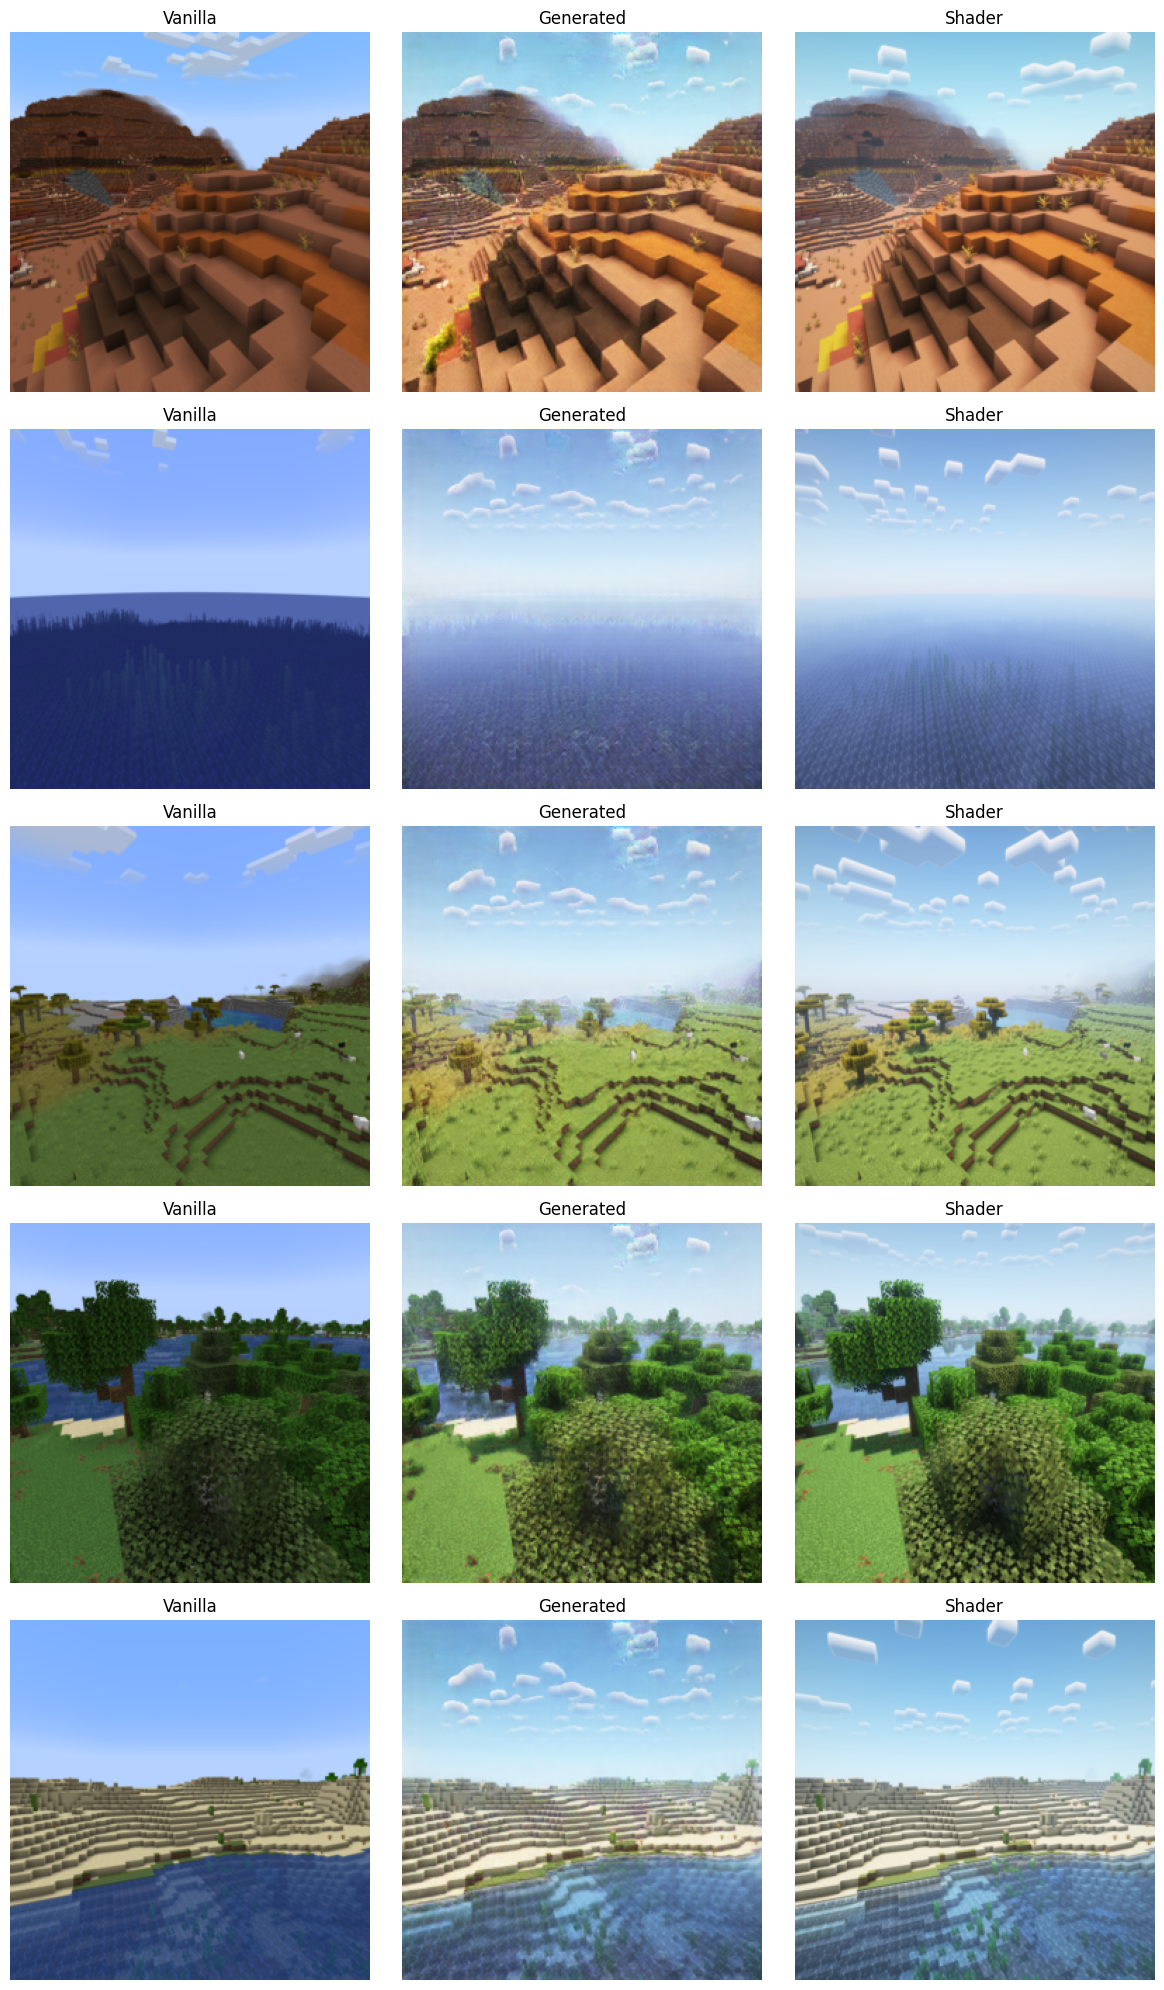

In [39]:
# Show results on test set
show_test_results(G, test_dl, device, num_samples=5)

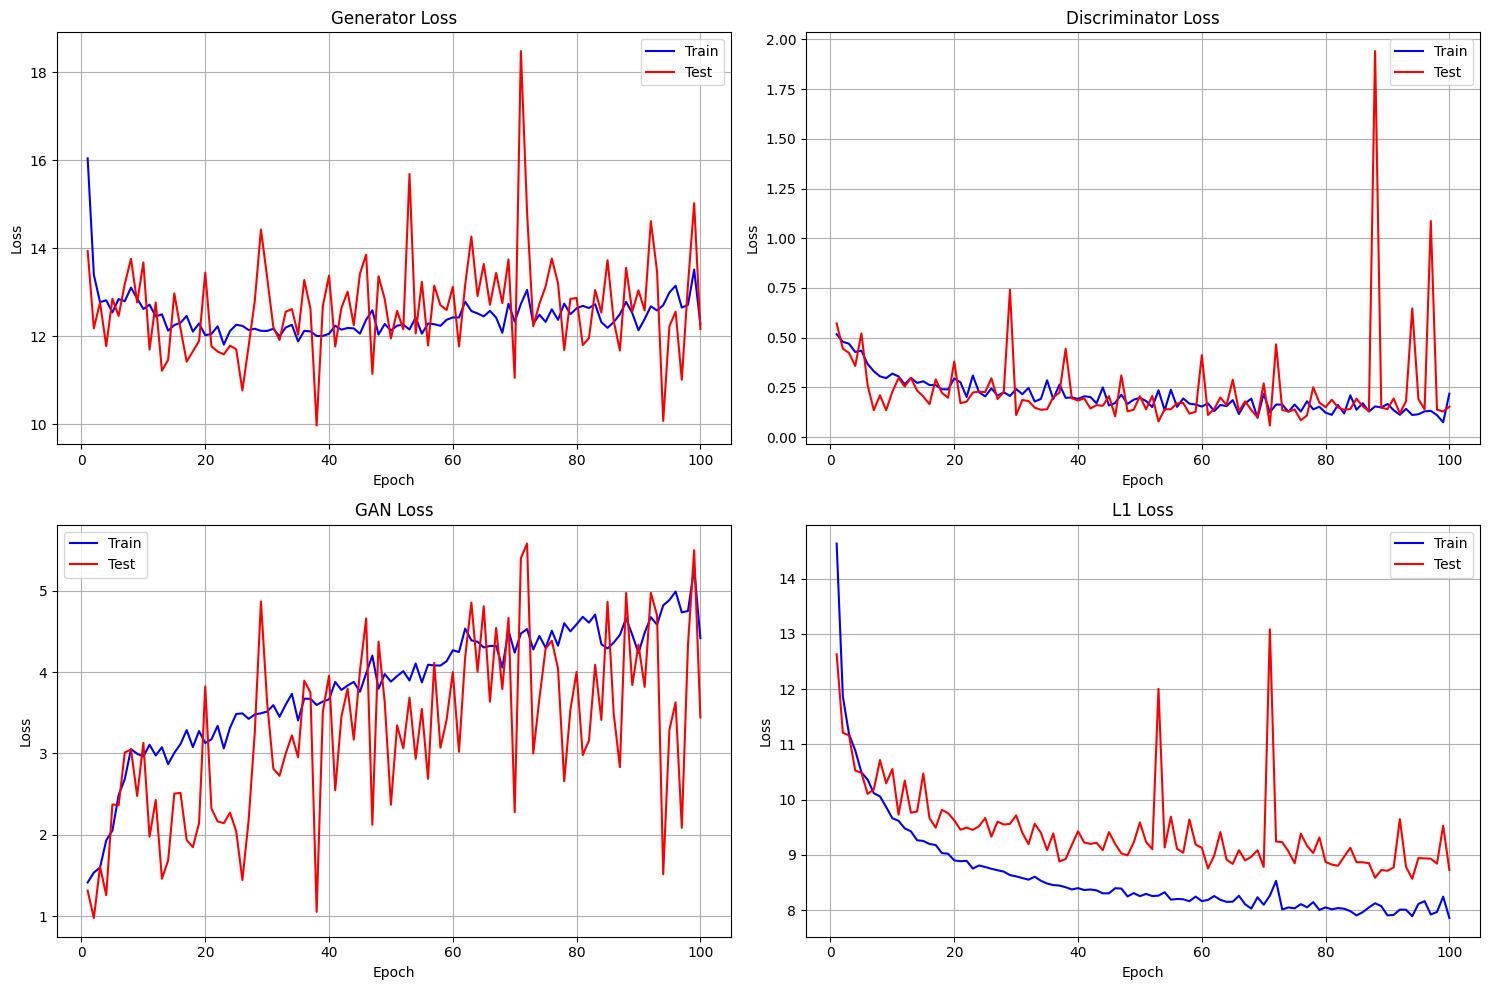


Final Metrics:
Train Generator Loss: 12.2751
Test Generator Loss: 12.1690
Train Discriminator Loss: 0.2182
Test Discriminator Loss: 0.1527


In [18]:
# Plot training and test metrics
plot_training_metrics(train_metrics, test_metrics)

# Print final metrics
print("\nFinal Metrics:")
print(f"Train Generator Loss: {train_metrics[-1]['generator_loss']:.4f}")
print(f"Test Generator Loss: {test_metrics[-1]['test_generator_loss']:.4f}")
print(f"Train Discriminator Loss: {train_metrics[-1]['discriminator_loss']:.4f}")
print(f"Test Discriminator Loss: {test_metrics[-1]['test_discriminator_loss']:.4f}")
